In [1]:
import hdf5plugin
import h5py    
import numpy as np  
import pandas as pd

In [2]:
def print_all_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            print(prefix + key)  # Print the dataset name
        elif isinstance(item, h5py.Group):
            print_all_datasets(item, prefix + key + '/')  # Recursively explore groups
            
def list_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, pd.DataFrame):
            print(prefix + key)  # Print the dataset path
        elif isinstance(item, pd.io.pytables.HDFStore):
            list_datasets(item, prefix + key + '/')  # Recursively explore groups


default_colors = {0: 'green', 1: 'blue', 2: 'orange', 3: 'red'}
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib

In [3]:
region_name = 'AIG_regions'
celltype = 'enterocytes'
fold = 'fold_0'
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv('region_scores/'+celltype+'/'+region_name+"/"+fold+".interpreted_regions.bed", sep='\t', names=NARROWPEAK_SCHEMA)

seq_length = 2114
regions_df['int_start'] = regions_df['start']+regions_df['summit']-seq_length/2
regions_df['int_end'] = regions_df['start']+regions_df['summit']+seq_length/2



In [4]:
def get_model_score(file_path,sequence_number):
    import h5py
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        dataset = f['shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get contribution_scores
        df = pd.DataFrame(dataset[sequence_number][:])
    
        # Access the dataset
        dataset = f['raw']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df2 = pd.DataFrame(dataset[sequence_number][:])


        # Access the dataset
        dataset = f['projected_shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df4 = pd.DataFrame(dataset[sequence_number][:])

    df3 = df*df2

    return(df2,df3)
        

In [5]:
sequence_number = 0
sequence_chr,sequence_start,sequence_end = regions_df.loc[sequence_number,'chr'],int(regions_df.loc[sequence_number,'int_start']),int(regions_df.loc[sequence_number,'int_end'])


import numpy as np
# Generate a 100bp grid
grid = np.linspace(0, 2114, num=22)
# Round each grid value to the nearest multiple of 100
rounded_grid = np.round(grid / 100) * 100
# Add starting position
grid2 = [x+sequence_start for x in rounded_grid]
# Round to nearest multiple of 100
rounded_grid2 = np.round(np.array(grid2) / 100) * 100
rounded_grid2 = [int(x) for x in rounded_grid2]
#Reset locations
tick_locations = [x-sequence_start for x in rounded_grid2]
#Add chr to first tick
rounded_grid2 = [str(x) for x in rounded_grid2]
rounded_grid2[0] = sequence_chr+": " + str(rounded_grid2[0])

In [6]:
model_scores_celltypes = {}
for celltype in ['enterocytes','EEC','Goblet_cell','Stem_cell']:
    
    seq_list = []
    folds = ['fold_0','fold_1','fold_2','fold_3','fold_4']
    i = 0
    for fold in folds:
    
        file_path = 'region_scores/'+celltype+'/'+region_name+"/"+fold+".profile_scores.h5"
        dataset_key = '/projected_shap/seq'  # Adjust the dataset key as needed
    
        seq,model_score_fold = get_model_score(file_path,sequence_number)
        seq_list.append(seq)
        if i == 0:
            model_score_sum = model_score_fold
            i+=1
        else:
            model_score_sum = model_score_sum + model_score_fold
    
    model_score_avg = model_score_sum/len(folds)
    model_scores_celltypes[celltype] = model_score_avg

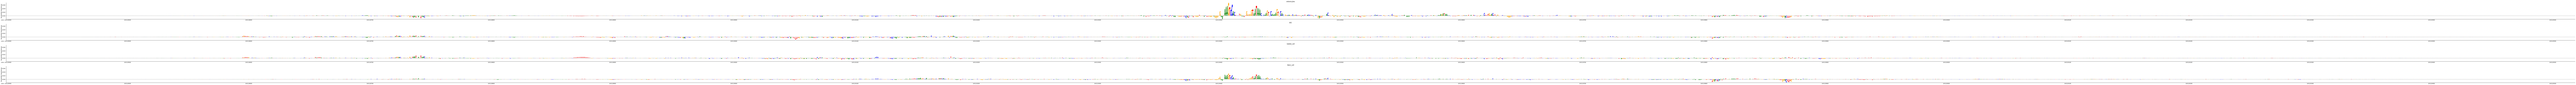

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np

# Assuming len_seq and celltypes are defined
len_seq = 2000
celltypes = ['enterocytes','EEC','Goblet_cell','Stem_cell']

# Create a figure
fig = plt.figure(figsize=(300/2000*len_seq, 2.5*len(celltypes)))

# Create a GridSpec with 1 column and rows equal to the number of cell types
gs = gridspec.GridSpec(len(celltypes), 1, figure=fig)

# Create axes in each grid cell with shared y-axis
axes = [fig.add_subplot(gs[i, 0]) for i in range(len(celltypes))]

# Plot each cell type
for ax, celltype in zip(axes, celltypes):
    ax.set_title(celltype)
    model_score_avg = model_scores_celltypes[celltype].copy()
    seq_df = model_score_avg.T
    seq_df.columns = ['A','C','G','T']
    
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, figsize=(300/2000*len_seq, 2.5), shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(rounded_grid2)

# Set shared y-axis limits (workaround, sharey does not work with logomaker)
y_min, y_max = np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(y_min, y_max)

# Display the plot
plt.tight_layout()
plt.savefig("region_plots/multi_celltypes/"+region_name+"_"+str(sequence_number)+".pdf",bbox_inches='tight',pad_inches=0)
plt.show()


In [8]:
celltypes = ['enterocytes','EEC','Goblet_cell','Stem_cell']

celltype_coverage = {}
for celltype in celltypes:
    model_score_avg = model_scores_celltypes[celltype].copy()
    seq_df = model_score_avg.T
    seq_df.columns = ['A','C','G','T']
    c = seq_df.sum().sum()

    celltype_coverage[celltype] = c

1190


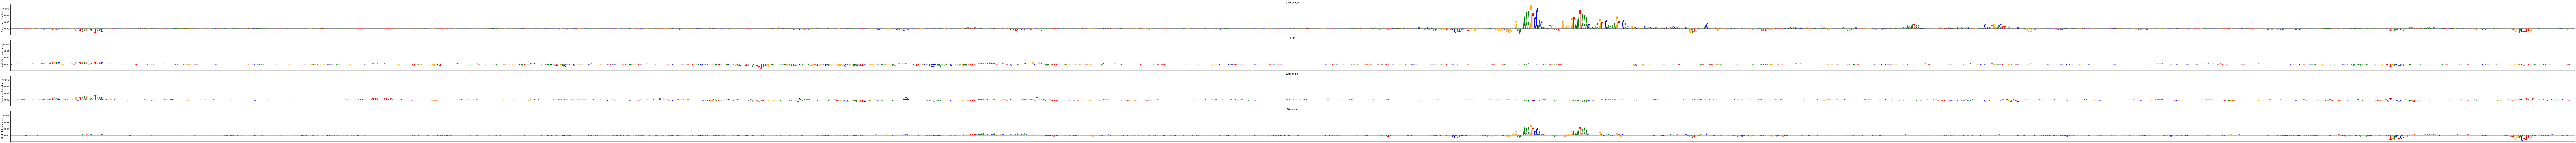

266


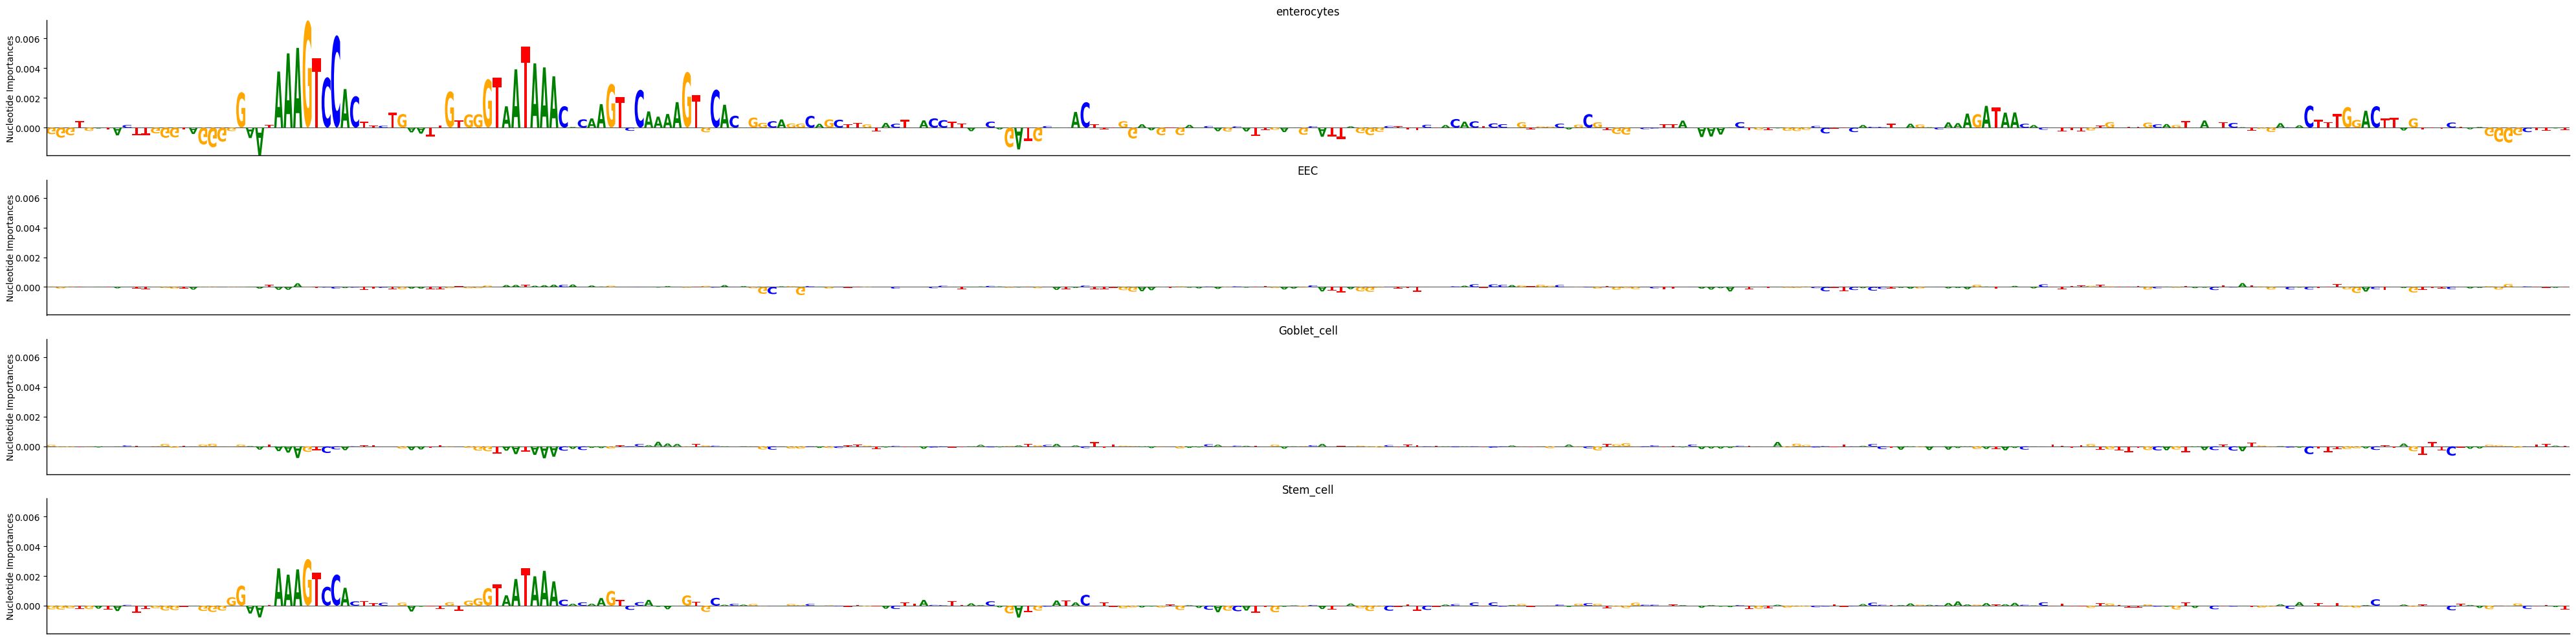

91


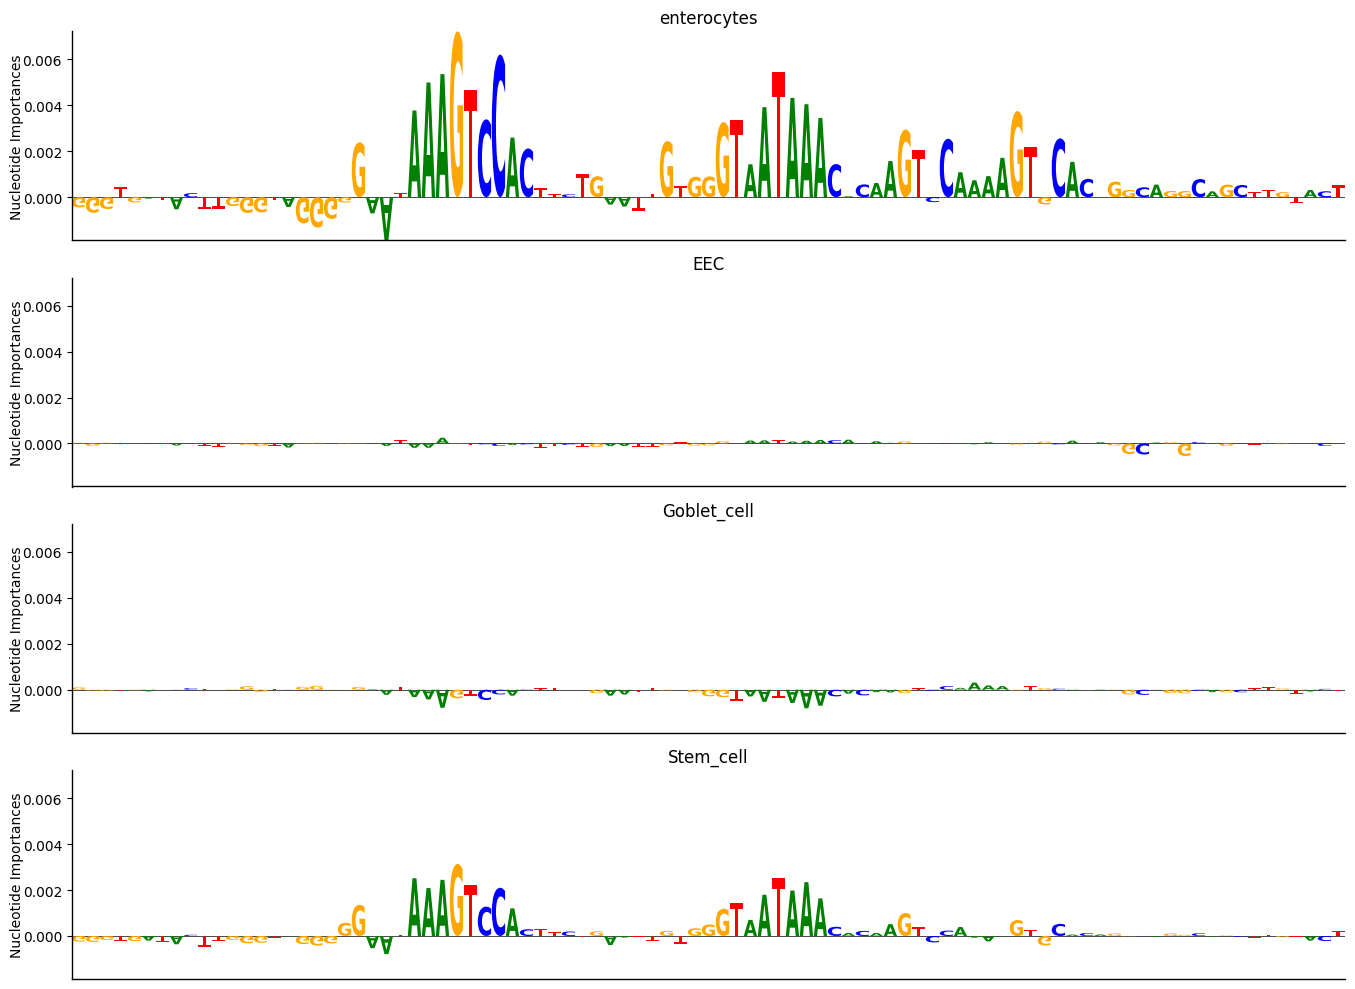

In [9]:
celltypes = ['enterocytes','EEC','Goblet_cell','Stem_cell']

max_key = max(celltype_coverage, key=celltype_coverage.get)

model_score_avg = model_scores_celltypes[max_key].copy()
seq_df = model_score_avg.T
seq_df.columns = ['A','C','G','T']

max_contrib = np.abs(seq_df.T).max()
max_contrib_Z = (max_contrib-max_contrib.mean())/max_contrib.std()

for Z_thresh in [1,3,5]:
    
    max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>Z_thresh]
    min_pos = np.array(max_contrib_Z_thresh.index).min()
    max_pos = np.array(max_contrib_Z_thresh.index).max()

    min_pos = np.max([min_pos - 20,1])
    max_pos = np.min([max_pos+20,2000])
    seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
    print(len(seq_df_trimmed.index))



    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import logomaker
    import numpy as np
    
    # Assuming len_seq and celltypes are defined
    len_seq = len(seq_df_trimmed.index)
    
    # Create a figure
    fig = plt.figure(figsize=(300/2000*len_seq, 2.5*len(celltypes)))
    
    # Create a GridSpec with 1 column and rows equal to the number of cell types
    gs = gridspec.GridSpec(len(celltypes), 1, figure=fig)
    
    # Create axes in each grid cell with shared y-axis
    axes = [fig.add_subplot(gs[i, 0]) for i in range(len(celltypes))]
    
    # Plot each cell type
    for ax, celltype in zip(axes, celltypes):
        ax.set_title(celltype)
        model_score_avg = model_scores_celltypes[celltype].copy()
        seq_df = model_score_avg.T
        seq_df.columns = ['A','C','G','T']

        #trim seq_df based on min and mox positions of highest celltype
        seq_df = seq_df.loc[min_pos:max_pos,:]

        # Create Logo object
        crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
        
        # Style using Logo methods
        crp_logo.style_spines(visible=False)
        crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
        crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
        
        # Style using Axes methods
        crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
        crp_logo.ax.xaxis.set_ticks_position('none')
        crp_logo.ax.xaxis.set_tick_params(pad=-1)
    
    # Set shared y-axis limits (workaround, sharey does not work with logomaker)
    y_min, y_max = np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        ax.set_ylim(y_min, y_max)
    
    # Display the plot
    plt.tight_layout()
    plt.savefig("region_plots/multi_celltypes/"+region_name+"_"+str(sequence_number)+"_Z"+str(Z_thresh)+".pdf",bbox_inches='tight',pad_inches=0)

    plt.show()
    plt.close()